# Education and Earnings: Unraveling the Impact of Higher Education on Income

Written by:
- Colin Chen
- Cici Liu
- Julian Widjaja
- Thomas Farrell


## 1. Introduction

One of the motivating factors for an individual to seek higher education is the belief that an advanced degree will lead to higher earning potential. But does a degree actually lead to higher earnings? 

A study of 2005 Ontario graduates supports this idea: researchers found statistically significant increases in earnings for each level of university education (Frank and Walters). A study by Kim et al. agreed but found significant variability in earning potential for different genders and fields of study. We will aim to confirm that a higher level of education leads to higher earnings, using a larger and more geographically widespread sample than the Ontario study. 

In this report, we will ask whether a person’s education level had an effect on their chance of earning more than \\$50,000 in 1994. We will investigate whether the proportion of people earning more than \$50,000 is significantly higher for those with a bachelor’s degree versus those without and whether it is again significantly higher for those with a master’s degree.

## 2. Preliminary Results

### Data Cleaning

In [1]:
install.packages("gridExtra")
library('tidyverse')
library("stringr")
library("broom")
library("infer")
library("gridExtra")
options(repr.plot.width=8, repr.plot.height=6)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




The dataset we will be using to answer this question is the “Adult” dataset from the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/2/adult).
We downloaded the dataset to the data folder. Now we read the data from the dataset and store it in `adult_data`.

In [2]:
bold <- function(text) {
  paste0("\033[1m", text, "\033[0m")
}

In [3]:
data_url <- "https://raw.githubusercontent.com/Julian-UBC/project-32/main/data/adult.data"
adult_data <- read.table(data_url, header=FALSE, sep= ",",
                 col.names = c("age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", "relationship", 
                               "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "class"))

adult_df <- as.data.frame(apply(adult_data, 2, str_remove_all, " "))

cat("\n\n")
cat(bold("Table 1: Original dataset with column names added"))
head(adult_df)

nrow(adult_df)
cat("\n\n")
cat("\n\n")
cat(bold("Table 2: A data frame signifying if any data is missing from any columns"))
adult_df |> summarize(across(everything(), list(na = ~ sum(is.na(.x)))))



Table 1: Original dataset with column names added

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,class
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
2,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
3,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
4,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
5,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
6,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


[1] 32561





Table 2: A data frame signifying if any data is missing from any columns

age_na,workclass_na,fnlwgt_na,education_na,education_num_na,marital_status_na,occupation_na,relationship_na,race_na,sex_na,capital_gain_na,capital_loss_na,hours_per_week_na,native_country_na,class_na
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


It contains 32561 observations with information taken from the 1994 US census database, and contains no missing values in any column.

We need to change some variable types before progressing:

In [4]:
dt <- adult_df %>%
    mutate(above_50_k = (class == ">50K"),
          hours_per_week = as.integer(hours_per_week))

Since we are primarily interested in people who received education in schools of learning and researching, we now filter out irrelevant categories in `education`. For our purpose, we also redefine the variable to group people into three segments: people without the bachelor's degree, people with the bachelor's degree, and those who earned a master's degree or higher.

In [5]:
data <- dt %>%
    filter(!education %in% c("Some-college", "Prof-school", "Assoc-acdm", "Assoc-voc")) %>%
    mutate(education = if_else(education == "Doctorate" | education == "Masters", "Master's or higher",
                       if_else(education == "Bachelors", "Bachelor's", "No Bachelor's"))) %>%
    mutate(education = factor(education))

cat("\n\n")
cat(bold("Table 3: A cleaned and tidy version of the original dataset"))
head(data)




Table 3: A cleaned and tidy version of the original dataset

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,class,above_50_k
,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<lgl>
1,39,State-gov,77516,Bachelor's,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,FALSE
2,50,Self-emp-not-inc,83311,Bachelor's,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,FALSE
3,38,Private,215646,No Bachelor's,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,FALSE
4,53,Private,234721,No Bachelor's,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,FALSE
5,28,Private,338409,Bachelor's,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,FALSE
6,37,Private,284582,Master's or higher,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K,FALSE


### Descriptive Statistics

After data wrangling, we would like to have an insight in the demographic composition of different groups who make either more or less than 50k. These will help us make reasonable decisions in adding more filtering layers to ensure the incomes for people with different education levels are comparative. It will also deepen our understanding to the divergence between groups that might be valuable in later reasoning for the difference.

#### Sample Distribution of Hours of Working



Figure 1: A histogram of different groups who make less than $50k USD

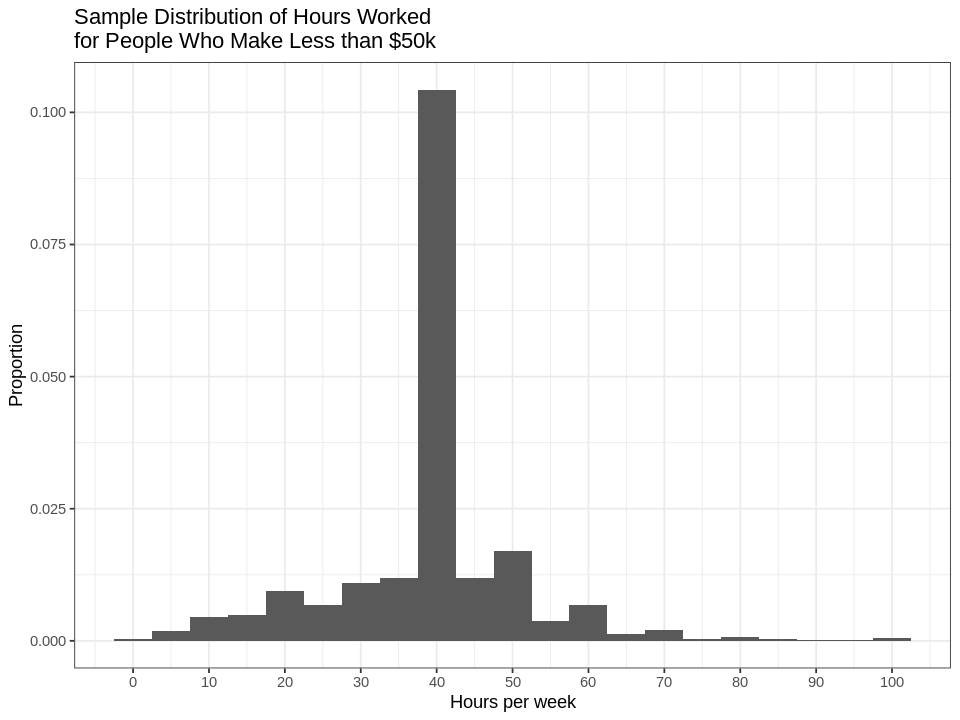





Figure 2: A histogram of different groups who make more than $50k USD

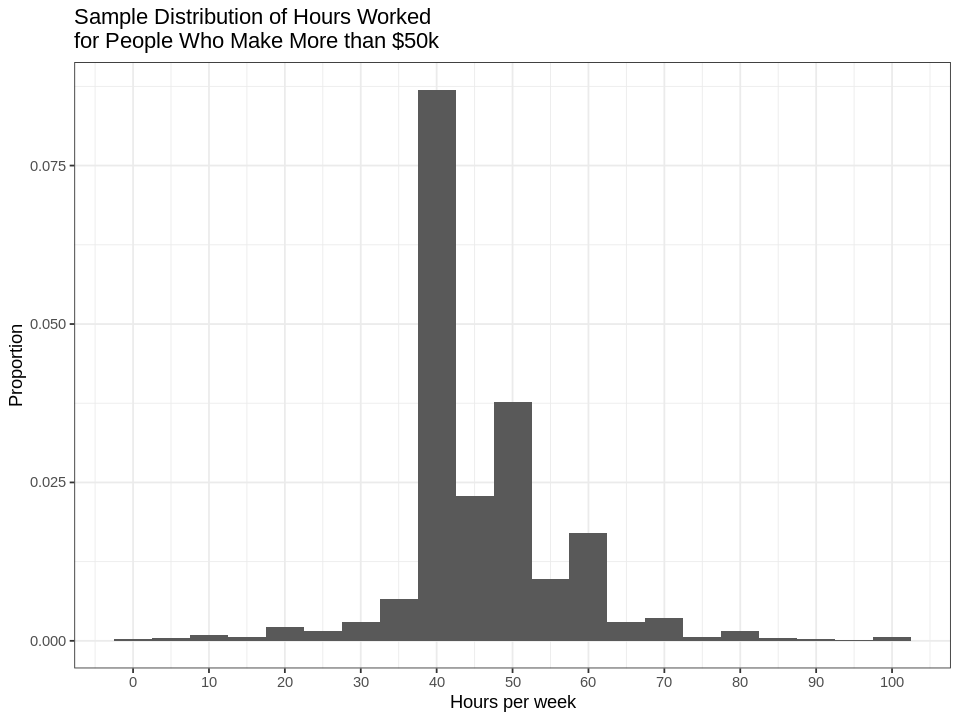

In [6]:
plot_below_50k <- data %>%
    filter(above_50_k == FALSE) %>%
    ggplot() +
    geom_histogram(aes(hours_per_week, ..density..), binwidth = 5) +
    scale_x_continuous(n.breaks = 10) +
    labs(x = "Hours per week", 
         y = "Proportion",
         title = "Sample Distribution of Hours Worked \nfor People Who Make Less than $50k") +
    theme(text = element_text(size = 14)) +
    theme_bw()
plot_below_50k
cat("\n\n")
cat(bold("Figure 1: A histogram of different groups who make less than $50k USD"))


plot_above_50k <- data %>%
    filter(above_50_k == TRUE) %>%
    ggplot() +
    geom_histogram(aes(hours_per_week, ..density..), binwidth = 5) +
    scale_x_continuous(n.breaks = 10) +
    theme(text = element_text(size = 14)) +
    labs(x = "Hours per week",
         y = "Proportion",
         title = "Sample Distribution of Hours Worked \nfor People Who Make More than $50k") +
    theme_bw()
plot_above_50k
cat("\n\n")
cat("\n\n")
cat(bold("Figure 2: A histogram of different groups who make more than $50k USD"))

From the plots, we see people who make more than $50k tend to spend more hours working than their lower-income counterpart. Specifically, more data are clustered greater than 40 hours for the higher-income group, while there is higher density of data below 40 hours for the lower-income group. To disinvolve the potential confounding variable, we will focus on individuals who work for 40 hours per week.

#### Sample Distribution of Sex



Figure 3: A bar plot for distribution of sex

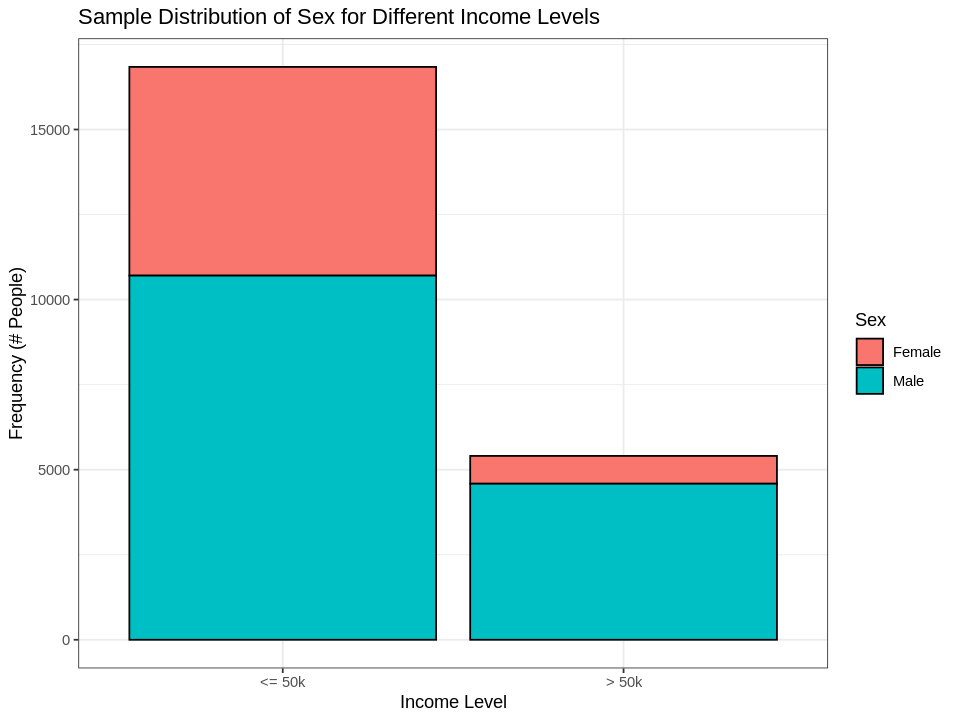

In [7]:
sex_plot <- data %>%
    ggplot(aes(x = above_50_k)) +
    geom_bar(aes(fill = sex), position="stack", color='black') +
    scale_x_discrete(labels=c("FALSE" = "<= 50k", "TRUE" = "> 50k")) +
    # geom_text(aes(label = paste0(round((..count../sum(..count..)),2)*100, "%")),
    #         stat = "count",
    #         position = position_stack(vjust = 0.5)) +
    labs(x = "Income Level", 
         y = "Frequency (# People)",
         fill = "Sex",
         title = "Sample Distribution of Sex for Different Income Levels") +
    theme(text = element_text(size = 14)) +
    theme_bw()
sex_plot
cat("\n\n")
cat(bold("Figure 3: A bar plot for distribution of sex"))

The stacked barplot above shows that the proportion of female in the low-income group is much higher than that in the high-income group.

#### Sample Distribution of Race



Figure 4: A bar plot for distribution of race

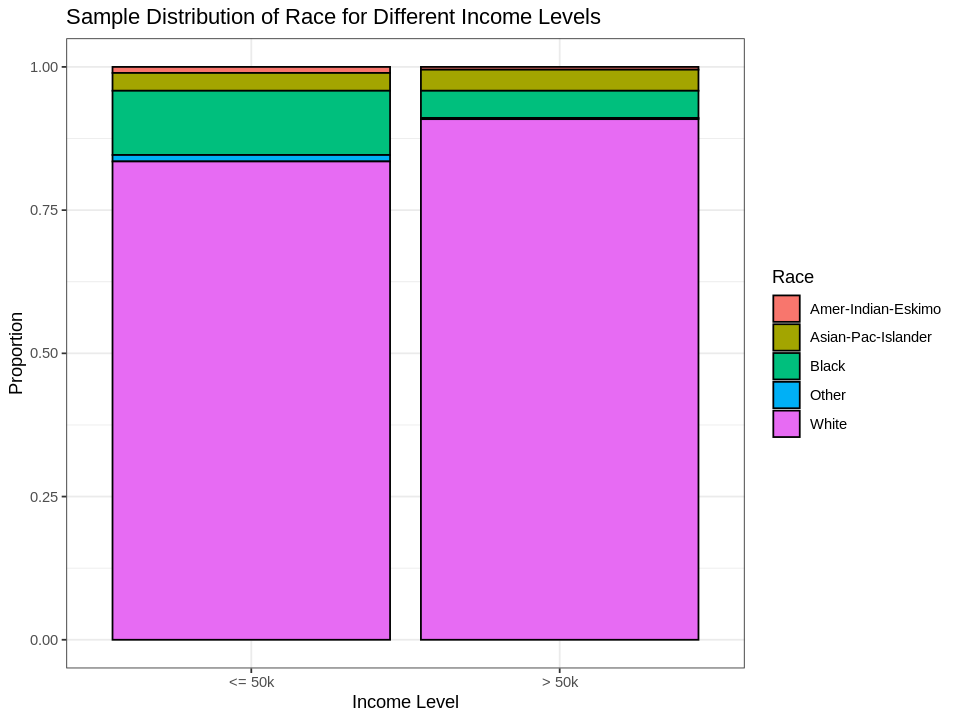

In [8]:
race_plot <- data %>%
    ggplot(aes(x = above_50_k)) +
    geom_bar(aes(fill = race), position="fill", color='black') +
    scale_x_discrete(labels=c("FALSE" = "<= 50k", "TRUE" = "> 50k")) +
    labs(x = "Income Level", 
         y = "Proportion",
         fill = "Race",
         title = "Sample Distribution of Race for Different Income Levels") +
    theme(text = element_text(size = 14)) +
    theme_bw()
race_plot 
cat("\n\n")
cat(bold("Figure 4: A bar plot for distribution of race"))

The plot shows that the proportion of Black people in the higher-income group is much lower than that in the lower-income group.

#### Paramater of Interest: Education and Income Level

The parameter of our interest is the proportion of people who make more than 50k per year with different educational level. We present them in a summary table here.

In [9]:
# 40 hours of work per week only
data_40 <- data %>%
    filter(hours_per_week == 40)

p_tbl <- data_40 %>%
    group_by(education, above_50_k) %>%
    summarize(prop = n()/nrow(data)) %>%
    group_by(education) %>%
    summarize(above_50_k = above_50_k,
              p = round(prop/sum(prop), 4))

cat("\n\n")
cat(bold("Table 4: P-value of different eduation background"))
p_tbl %>% filter(above_50_k == TRUE) %>% select(-above_50_k)

`summarise()` has grouped output by 'education'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'education'. You can override using the
`.groups` argument.




Table 4: P-value of different eduation background

education,p
<fct>,<dbl>
Bachelor's,0.3632
Master's or higher,0.5475
No Bachelor's,0.1294


To visualize the parameter:



Figure 5: A bar plot for proportion of income to 50k at different education levels

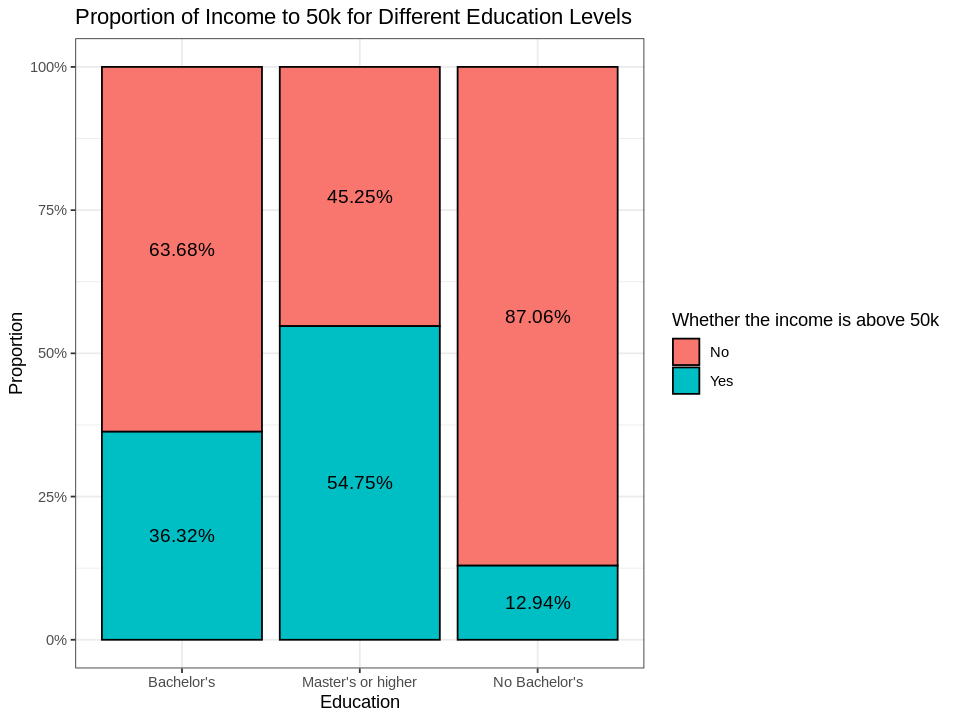

In [10]:
education_proportion_plot <- p_tbl %>%
  ggplot(aes(x = education, y = p, fill = above_50_k)) +
  geom_bar(position = "fill", stat = "identity", color='black', width=0.9) +
  scale_y_continuous(labels = scales::percent) +
  geom_text(aes(label = paste0(p*100,"%")), 
            position = position_stack(vjust = 0.5), size = 4) +
  labs(x = "Education",
      y = "Proportion",
      fill = "Whether the income is above 50k",
      title = "Proportion of Income to 50k for Different Education Levels") + 
  theme(text = element_text(size = 14)) +
  scale_fill_discrete(labels=c('No', 'Yes')) +
  theme_bw()
education_proportion_plot
cat("\n\n")
cat(bold("Figure 5: A bar plot for proportion of income to 50k at different education levels"))

Both from the table and the plot, we see a sharp increase in the proportion of people who make more than 50k as people gain higher educational degree. We will use the statistical inferential method to further demonstrate it.

## 3. Methods & Results

The report starts with a clear data cleaning process and clearly defines the parameter of interest and includes descriptive statistics to provide insights. The data is taken from a reliable source through UCI Machine Learning Repository where we have a large sample of an equal representation. However, visualizations and point estimates alone are not sufficient for making informed decisions. To draw robust conclusions, we will conduct a hypothesis test to assess whether the observed differences in the proportions of individuals earning more than $50k across education levels are statistically significant or if they could have occurred due to random chance.

### ANOVA test
Since we are dealing with multiple groups, we will first conduct an ANOVA test to see if the differences in proportions of individuals earning more than $50k are significant. The hypothesis tests we are using:

<div align="center"> 
    $H_0$: the proportions of people with an annual salary $\geq$ 50k are equal among the three education levels</div>
<div align="center"> 
    $H_a$: at least one proportion of people with an annual salary $\geq$ 50k is different to the other education levels </div>

In [11]:
sample_statistics <- data_40 |>
    group_by(education) |>
    summarize(prop = mean(above_50_k), n = n()) |>
    arrange(prop)

cat("\n\n")
cat(bold("Table 5: A table for different eduation levels and their proportion and amount"))
sample_statistics



Table 5: A table for different eduation levels and their proportion and amount

education,prop,n
<fct>,<dbl>,<int>
No Bachelor's,0.1293915,7543
Bachelor's,0.3632014,2299
Master's or higher,0.5475285,789


In [12]:
cat("\n\n")
cat(bold("Table 6: Summary of the analysis of variance model"))
aov(above_50_k ~ education, data_40) |> tidy()



Table 6: Summary of the analysis of variance model

term,df,sumsq,meansq,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
education,2,192.8483,96.424162,649.8767,5.380854e-267
Residuals,10628,1576.9084,0.148373,NA,NA


From this analysis of variance, at a 0.1% significance level we reject the null and conclude that at least one of the proportions is different to the others. We will now run paired z-tests to find out which ones are different by using both asymptotics and bootstrapping.

### Paired $z$-tests: Asymptotic Approach
Let $p_1$ and $p_2$ denote the proportions of people with an annual salary $\geq$ 50k in the two groups under comparison, where $p_2$ is always the proportion for the group of the higher educational level. Then the hypothesis tests that we use are:

<div align="center"> $H_0: p_2 - p_1 = 0$
<div>
<div align="center"> $H_a: p_2 - p_1 > 0$ (or equivalently $H_a: p_1 - p_2 < 0$)
<div>

Since the population distribution of whether earning a salary above 50k only takes 0 or 1, we have to rely on the Central Limit Theorem (CLT) for the normality of the sampling distribution. We check if the assumptions for CLT are met:

In [13]:
pooled_p <- function(p1, p2, n1, n2) {
    return((n1*p1 + n2*p2) / (n1 + n2))}

data1 <- data_40 |> filter(education == "Bachelor's" | education == "No Bachelor's")
data2 <- data_40 |> filter(education == "Bachelor's" | education == "Master's or higher")
data3 <- data_40 |> filter(education == "No Bachelor's" | education == "Master's or higher")

assumptions <- tibble(sample = c("Bachelor's vs. None", "Master's vs. Bachelor's", "Master's vs. None"),
                    p_hat = c(pooled_p(sample_statistics$prop[2], sample_statistics$prop[1], sample_statistics$n[2], sample_statistics$n[1]),
                                pooled_p(sample_statistics$prop[3], sample_statistics$prop[2], sample_statistics$n[3], sample_statistics$n[2]),
                                pooled_p(sample_statistics$prop[3], sample_statistics$prop[1], sample_statistics$n[3], sample_statistics$n[1])),
                     n = c(nrow(data1), nrow(data2), nrow(data3))) |>
                mutate(np = p_hat*n, n1_p = (1-p_hat)*n)

cat("\n\n") 
cat(bold("Table 7: A table for comparison assumptions for education-level proportions"))
assumptions



Table 7: A table for comparison assumptions for education-level proportions

sample,p_hat,n,np,n1_p
<chr>,<dbl>,<int>,<dbl>,<dbl>
Bachelor's vs. None,0.1840073,9842,1811,8031
Master's vs. Bachelor's,0.4102979,3088,1267,1821
Master's vs. None,0.1689870,8332,1408,6924


From the `np` and `n1_p` columns, we see our sample size is large enough that $n\hat{p}$ and $n(1-\hat{p})$ for all three subgroups that contain two education levels are much larger than 10. Thus, we confirm that the approximation of the sampling distribution under $H_0$ of the test statistic $Z$ by $N(0,1)$ is good.

Now we compute the test statistics $Z$ and its corresponding $p$-values.

In [14]:
test_z <- function(p1, p2, n1, n2) {
    pooled = (n1*p1 + n2*p2) / (n1 + n2)
    return((p1 - p2) / sqrt(pooled*(1 - pooled) * (1/n1 + 1/n2)))
}
test_statistics <- tibble(test = c("Bachelor's vs. None", "Master's vs. Bachelor's", "Master's vs. None"),
                          z = c(test_z(sample_statistics$prop[2], sample_statistics$prop[1], sample_statistics$n[2], sample_statistics$n[1]),
                                test_z(sample_statistics$prop[3], sample_statistics$prop[2], sample_statistics$n[3], sample_statistics$n[2]),
                                test_z(sample_statistics$prop[3], sample_statistics$prop[1], sample_statistics$n[3], sample_statistics$n[1]))) |>
    mutate(p_value = pnorm(-z))

cat("\n\n") 
cat(bold("Table 8: A table for Z-test statistics and P-values for education-level proportion comparisons"))
test_statistics




Table 8: A table for Z-test statistics and P-values for education-level proportion comparisons

test,z,p_value
<chr>,<dbl>,<dbl>
Bachelor's vs. None,25.328069,7.839183e-142
Master's vs. Bachelor's,9.082232,5.318526e-20
Master's vs. None,29.821120,1.039981e-195


Since we implement three $z$-tests at a time, we do $p$-value correction by using the Bonferroni adjustment.

In [15]:
test_statistics <- test_statistics |>
    mutate(p_value = p.adjust(p_value, method = "bonferroni"))

cat("\n\n") 
cat(bold("Table 9: Adjusted P-values using bonferroni correction for education-level proportion comparisons"))
test_statistics




Table 9: Adjusted P-values using bonferroni correction for education-level proportion comparisons

test,z,p_value
<chr>,<dbl>,<dbl>
Bachelor's vs. None,25.328069,2.351755e-141
Master's vs. Bachelor's,9.082232,1.595558e-19
Master's vs. None,29.821120,3.119944e-195


At a 0.1% significance level, we reject all three null hypotheses and conclude that people with bachelor's degrees indeed had a higher chance of earning more than $50,000 annually than people without, and people with master's degrees had a still higher chance.

### Paired $z$-tests: Bootstrapping

Then we want to confirm the results by repeating the hypothesis tests using the bootstrapping method, seeing if it would be consistent to the asymotitics approach.

In [16]:
null_model <- function(data, edu1, edu2) {
    data %>%
    specify(formula = above_50_k ~ education, success = "TRUE") %>%
    hypothesize(null = "independence") %>%
    generate(reps = 1000, type = "permute") %>%
    calculate(stat = "diff in props", order = c(edu1, edu2))
}

In [17]:
# observed statistics
non_bachelor_bachelor_diff <- sample_statistics$prop[1] - sample_statistics$prop[2]
bachelor_master_diff <- sample_statistics$prop[2] - sample_statistics$prop[3]
non_bachelor_master_diff <- sample_statistics$prop[1] - sample_statistics$prop[3]

In [18]:
set.seed(812)

# bootstrapping distribution
null_model_non_bachelor_bachelor <- null_model(data1, "No Bachelor's", "Bachelor's")
null_model_bachelor_master <- null_model(data2, "Bachelor's", "Master's or higher")
null_model_non_bachelor_master <- null_model(data3, "No Bachelor's", "Master's or higher")

head(null_model_non_bachelor_bachelor)
head(null_model_bachelor_master)
head(null_model_bachelor_master)

Dropping unused factor levels Master's or higher from the supplied explanatory variable 'education'.

Dropping unused factor levels No Bachelor's from the supplied explanatory variable 'education'.

Dropping unused factor levels Bachelor's from the supplied explanatory variable 'education'.



replicate,stat
<int>,<dbl>
1,-0.002251554
2,-0.026655988
3,0.007964256
4,0.000586171
5,0.019315155
6,-0.006791914


replicate,stat
<int>,<dbl>
1,-0.0481352172
2,-0.0225992345
3,-0.0038728471
4,0.0471991184
5,0.0216631356
6,-0.0004680494


replicate,stat
<int>,<dbl>
1,-0.0481352172
2,-0.0225992345
3,-0.0038728471
4,0.0471991184
5,0.0216631356
6,-0.0004680494


We want to visualize the null model and the observed statistics.

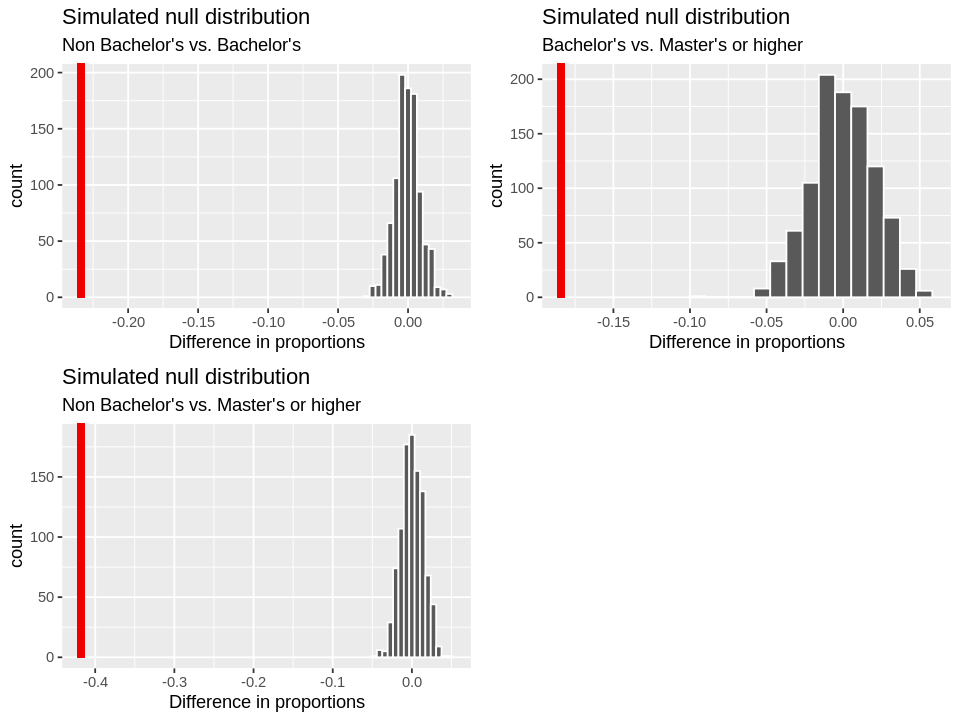

In [19]:
non_bachelor_bachelor_plot <- 
    null_model_non_bachelor_bachelor %>%
    visualize() + 
    shade_p_value(obs_stat = non_bachelor_bachelor_diff, direction = "left") +
    xlab("Difference in proportions") +
    ggtitle("Simulated null distribution", subtitle = "Non Bachelor's vs. Bachelor's")

bachelor_master_plot <- 
    null_model_bachelor_master %>%
    visualize() + 
    shade_p_value(obs_stat = bachelor_master_diff, direction = "left") +
    xlab("Difference in proportions") +
    ggtitle("Simulated null distribution", subtitle = "Bachelor's vs. Master's or higher")

non_bachelor_master_plot <- 
    null_model_non_bachelor_master %>%
    visualize() + 
    shade_p_value(obs_stat = non_bachelor_master_diff, direction = "left") +
    xlab("Difference in proportions") +
    ggtitle("Simulated null distribution", subtitle = "Non Bachelor's vs. Master's or higher")

grid.arrange(non_bachelor_bachelor_plot, bachelor_master_plot, non_bachelor_master_plot, ncol=2)

The plots show that it is very unlikely to obtain the observed differences in proportions if the null hypothesis is true. To confirm it, we compute the $p$-value:

In [20]:
non_bachelor_bachelor_p_value <- 
    null_model_non_bachelor_bachelor %>%
    get_p_value(obs_stat = non_bachelor_bachelor_diff, direction = "left")

bachelor_master_p_value <- 
    null_model_bachelor_master %>%
    get_p_value(obs_stat = bachelor_master_diff, direction = "left")

non_bachelor_master_p_value <- 
    null_model_non_bachelor_master %>%
    get_p_value(obs_stat = non_bachelor_master_diff, direction = "left")

bootstrapping_test_results <- 
    tibble(test = c("Bachelor's vs. None", "Master's vs. Bachelor's", "Master's vs. None"),
          p_value = c(non_bachelor_bachelor_p_value, bachelor_master_p_value, non_bachelor_master_p_value))

bootstrapping_test_results

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”
Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”
Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


test,p_value
<chr>,<named list>
Bachelor's vs. None,0
Master's vs. Bachelor's,0
Master's vs. None,0


We need to do the $p$-value correction since we are conducting multiple tests on the same dataset simultaneously.

In [21]:
bootstrapping_test_results <- bootstrapping_test_results |>
    mutate(p_value = p.adjust(p_value, method = "bonferroni"))

bootstrapping_test_results

test,p_value
<chr>,<dbl>
Bachelor's vs. None,0
Master's vs. Bachelor's,0
Master's vs. None,0


Again at a 0.1% significance level, we reject all three null hypotheses and conclude that people with bachelor's degrees indeed had a higher chance of earning more than $50,000 annually than people without, and people with master's degrees had a still higher chance.

### Comparison between Asymptotics and Bootstrapping
The asymptotic and bootstrapping methods give the similar result that higher educational level is associated with an higher average salary. This is explainable since we can infer from the observed differences in proportions that the effect size of our tests are fairly large, so that both methods would give significant results.

However, since the bootstrapping does not assume any underlying distribution of the data (for example, we are unclear about the data sampling procedure and thus conclude the data are independent), its result would be more accurate and reliable.

## Discussions

**Summarize what you found, and the implications/impact of your findings**

ENTER YOUR ANSWER HERE.

**If relevant, discuss whether your results were what you expected to find**

From the investigation, it seems like the result supports the claim that a higher level of education leads to higher earnings, as individuals with higher education levels (e.g., college or advanced degrees) have a higher likelihood of earning at least $50,000 compared to those with lower education levels (e.g., high school or lower). Previous studies compared community college graduates with individuals with a four-year bachelor's degree and it was “consistently revealed that 2-year entrants” would have a “lower salary growth than their 4-year sector counterparts” (González Canché, 2016). By following analogous patterns, we would anticipate observing similar outcomes.

**Discuss future questions/research this study could lead to**

Upon analyzing the final results, a natural progression would be to further establish the causation by asking some follow-up questions; Does higher education directly cause higher income or are there other intricating factors involved? It is imperative to distinguish between correlation—merely a connection between variables—and causation, where one directly instigates changes in the other.

Additional research could focus on exploring other factors that may mediate the relationship between education and income, such as job experience. Studies can be conducted on the long-term and short-term effects, such as the trajectories of salary growth with post-education required careers. Perhaps one may want to research the type of education or degrees one pursues and if they can vary the income.

The study itself may raise questions about the determinants of income, such as job market conditions, job availability, and other industry factors. For instance, the economic consequences of the coronavirus led to the over-saturation of technological job positions, which caused a subsequent decline in career opportunities post-pandemic. In essence, studying the relationship between education levels and income status can yield valuable insights into the significant role that education potentially plays in economic outcomes.


## References

Frank, K., and D. Walters. “Exploring the Alignment Between Postsecondary Education Programs and Earnings: An Examination of 2005 Ontario Graduates”. Canadian Journal of Higher Education, vol. 42, no. 3, Dec. 2012, pp. 93-115, doi:10.47678/cjhe.v42i3.1866.

González Canché, Manuel S. “Community College Scientists and Salary Gap: Navigating Socioeconomic and Academic Stratification in the U.S. Higher Education System.” The Journal of Higher Education, vol. 88, no. 1, 2016, pp. 1–32, https://doi.org/10.1080/00221546.2016.1243933.

Kim, ChangHwan, et al. “Field of Study in College and Lifetime Earnings in the United States.” Sociology of Education, vol. 88, no. 4, SAGE Publishing, Sept. 2015, pp. 320–39. https://doi.org/10.1177/0038040715602132.